In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets, cluster, mixture
from time import time
import warnings

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

%matplotlib inline

### t-SNE plot for movement vectors of cows
- t-SNE visualization of movement vectors with **different perplexity values**
- Reference
    - [t-SNE: The effect of various perplexity values on the shape](http://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py)
    - [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)

cow movements, perplexity=30 in 1.2e+02 sec
cow movements, perplexity=50 in 1.6e+02 sec
cow movements, perplexity=100 in 2.3e+02 sec


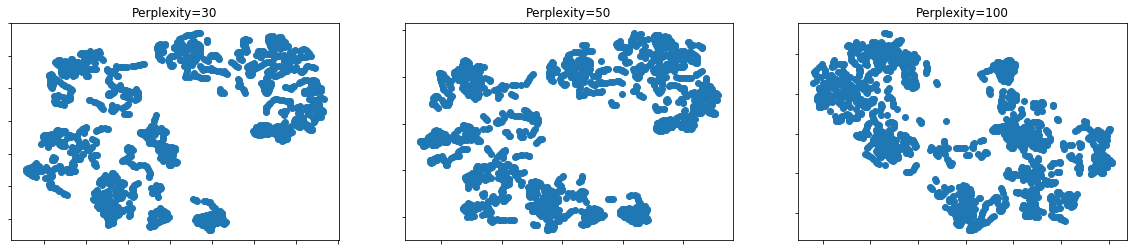

In [43]:
n_components = 2
(fig, subplots) = plt.subplots(1, 3, figsize=(20, 4), squeeze=False)
perplexities = [30, 50, 100]

in_dir = 'D:/Canon+JA/20180814 モデルソース/keras-frcnn'
in_file = os.path.join(in_dir, 'move_vectors_0817_32_all_2lstm.csv')

movements = np.loadtxt(in_file, delimiter=',')

Xs = []
for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random', n_iter=5000,
                         random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(movements)
    Xs.append(X)
    t1 = time()
    print("cow movements, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(X[:, 0], X[:, 1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()
fig.savefig('./t-SNE.png')

### Clustering of t-SNE datasets
- Clustering on **all** the above resulting datasets of t-SNE
- Using **all** the clustering algorithms to find the **optimized clustering result**
- Reference
    - [Comparing different clustering algorithms on toy datasets](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

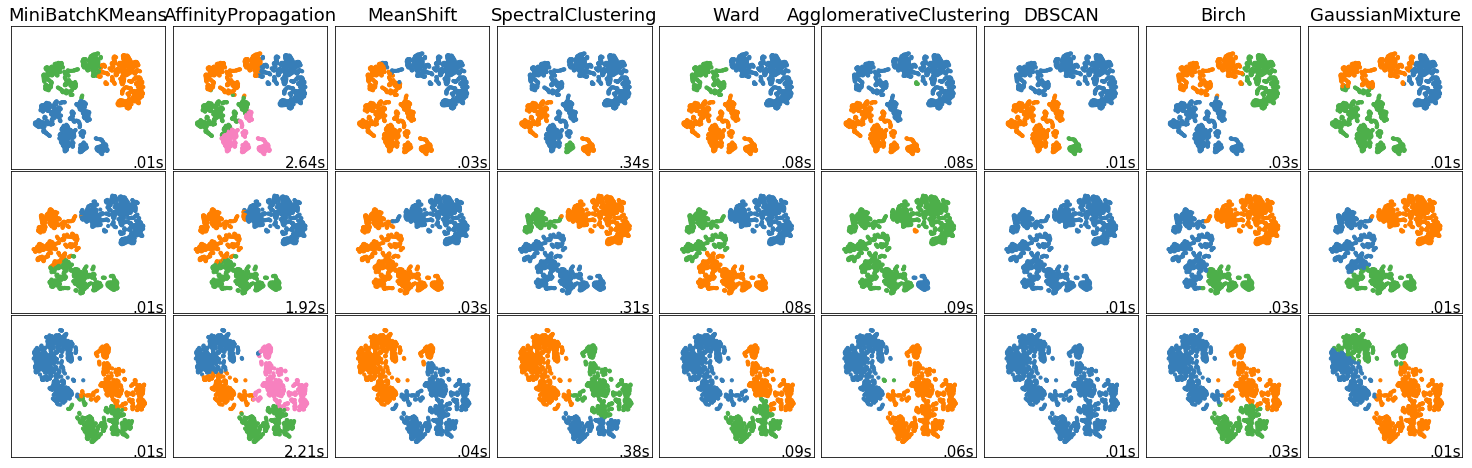

In [47]:
np.random.seed(0)

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

for i_dataset, X in enumerate(Xs):
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.savefig('./cluster.png')
plt.show()

### Use the labels of the best culstering
- Fourth diagram on the second row.

In [48]:
in_dir = 'D:/Canon+JA/20180814 モデルソース/keras-frcnn'
y_pred = ward.fit_predict(Xs[1])
Xy = np.hstack((movements, y_pred.reshape(-1, 1)))
np.savetxt(os.path.join(in_dir, 'move_vectors_0817_32_all_2lstm_y_ward.csv'), Xy, delimiter=',')